In [1]:
import sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore')

import copy
import pickle
import numpy as np
from time import time
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
from torch import distributed as dist
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, TensorDataset

from src.utils import *
from src.classifier import Classifier
from src.gan import Generator, Discriminator, DistributionDiscriminator
from src.baselines import risk_minimization, valid_classifier
from src.train_gan import train_gan, generate_dataset_from_gan
from src.data_generator import generate_sequential_datasets

np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.

<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.

<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.



# 1. Parameters

In [2]:
# 文件保存
experiment = 2

# 生成数据集
no = 10000
x_dim = 6
seq_len = 10
hiddens = [x_dim + 1, 32, 64, 1]
epsilon = 0.1

# 数据预处理
test_size = 0.2
valid_size = 0.125
batch_size = 512

# Step1: 训练Classifier
c_hiddens = [x_dim + 1, 32, 64, 1]

# Step2: 训练GAN
g_hidden_size = 64
g_num_layers = 2
d_hidden_size = 64
d_num_layers = 2
gan_epochs = 3000

# Step3: 重训练Classifier
dp_lambda = 0.8

# 使用CPU或GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### 1.1 Save Files

In [3]:
res_path = Path('../res')
log_dir = res_path / f'experiments_{experiment}'
true_path = log_dir / (f"true_model_" + ".pth")
clf_path = log_dir / (f"c_model_" + ".pth")
gan_path = log_dir / (f"gan_model_" + str(gan_epochs) + "_" + str(g_hidden_size) + ".pth")
re_clf_path = log_dir / (f"dp_model-" + str(dp_lambda)+ ".pth")
tsne_path = log_dir / (f"syn-tsne.png")

if not res_path.exists():
    res_path.mkdir()

if not log_dir.exists():
    log_dir.mkdir(parents=True)


# 2. Generate Synthetic Dataset

In [4]:
s0, x, y, gt_model = generate_sequential_datasets(no, x_dim, seq_len, hiddens, epsilon, device, true_path)
gt_model.to(device)

Time:  4.45s


TrueModel(
  (model): Sequential(
    (0): Linear(in_features=7, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): Sigmoid()
  )
  (loss_fn): BCELoss()
)

### 2.1 Processing Datasets

In [5]:
# 划分训练集和测试集
s_train, s_test, x_train, x_test, y_train, y_test = train_test_split(s0, x, y, test_size=test_size, random_state=10)
s_train, s_valid, x_train, x_valid, y_train, y_valid = train_test_split(s_train, x_train, y_train, test_size=valid_size, random_state=10)
print(s_train.shape, x_train.shape, y_train.shape)

# 把数据标准化到[0, 1]区间
scalers = [MinMaxScaler() for _ in range(seq_len)]
for i in range(seq_len):
    x_train[:, i] = scalers[i].fit_transform(x_train[:, i])
    x_valid[:, i] = scalers[i].transform(x_valid[:, i])
    x_test[:, i] = scalers[i].transform(x_test[:, i])

# 生成数据生成器
train_data = TensorDataset(tensor(s_train), tensor(x_train), tensor(y_train))
valid_data = TensorDataset(tensor(s_valid), tensor(x_valid),tensor(y_valid))
test_data = TensorDataset(tensor(s_test), tensor(x_test), tensor(y_test))
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size=len(valid_data), shuffle=False)
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

(7000, 1) (7000, 10, 6) (7000, 10, 1)


### 2.2 Visualization

In [6]:
data_distance(s_train, x_train[:, 0])
data_distance(s_valid, x_valid[:, 0])
data_distance(s_test, x_test[:, 0])
print(" ")
data_distance(s_train, x_train[:, -1])
data_distance(s_valid, x_valid[:, -1])
data_distance(s_test, x_test[:, -1])

X0-X1-W-dis: tensor(0.2944)
X0-X1-W-dis: tensor(0.3284)
X0-X1-W-dis: tensor(0.3125)
 
X0-X1-W-dis: tensor(0.2862)
X0-X1-W-dis: tensor(0.3174)
X0-X1-W-dis: tensor(0.3010)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.089818
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.565460
[t-SNE] KL divergence after 1000 iterations: 1.005143


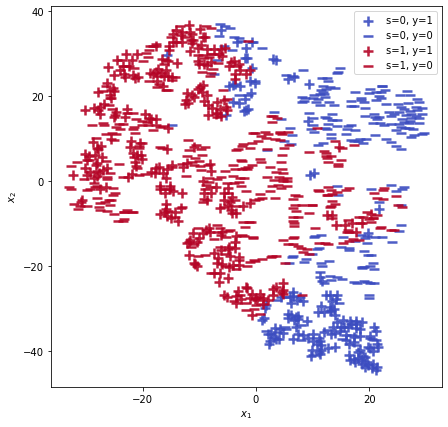

In [7]:
visualize_step_data(s_train, x_train, y_train, step=0)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.080247
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.240814
[t-SNE] KL divergence after 1000 iterations: 0.650886


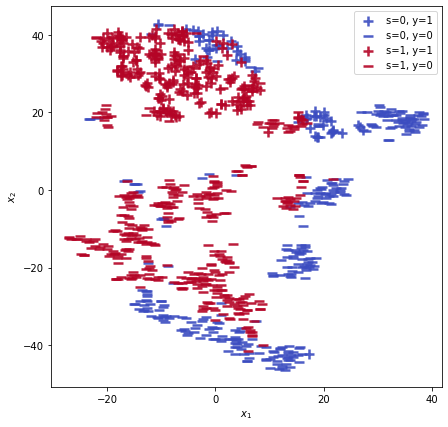

In [8]:
visualize_step_data(s_train, x_train, y_train, step=-1)

# 2. Train Classifier

In [9]:
clf = Classifier(c_hiddens)
clf.to(device)

Classifier(
  (model): Sequential(
    (0): Linear(in_features=7, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): Sigmoid()
  )
  (loss_fn): BCELoss()
)

In [10]:
if not clf_path.exists():
    clf.fit(train_loader, valid_loader, clf_path, device)

In [11]:
clf.load_state_dict(torch.load(clf_path, map_location=device))
clf.eval(test_loader, device)

#(S=0): 741, #(S=1): 1259, #(y0): 1131, #(y1): 869, P(y=1|s=0)=0.422, P(y=1|s=1)=0.442
Step:      0, ACC:  83.00%, FAIR:   0.02

#(S=0): 741, #(S=1): 1259, #(y0): 1254, #(y1): 746, P(y=1|s=0)=0.267, P(y=1|s=1)=0.435
Step:      1, ACC:  87.50%, FAIR:   0.17

#(S=0): 741, #(S=1): 1259, #(y0): 1308, #(y1): 692, P(y=1|s=0)=0.224, P(y=1|s=1)=0.418
Step:      2, ACC:  90.65%, FAIR:   0.19

#(S=0): 741, #(S=1): 1259, #(y0): 1316, #(y1): 684, P(y=1|s=0)=0.200, P(y=1|s=1)=0.426
Step:      3, ACC:  90.65%, FAIR:   0.23

#(S=0): 741, #(S=1): 1259, #(y0): 1300, #(y1): 700, P(y=1|s=0)=0.224, P(y=1|s=1)=0.424
Step:      4, ACC:  92.10%, FAIR:   0.20

#(S=0): 741, #(S=1): 1259, #(y0): 1310, #(y1): 690, P(y=1|s=0)=0.219, P(y=1|s=1)=0.419
Step:      5, ACC:  91.55%, FAIR:   0.20

#(S=0): 741, #(S=1): 1259, #(y0): 1313, #(y1): 687, P(y=1|s=0)=0.212, P(y=1|s=1)=0.421
Step:      6, ACC:  92.25%, FAIR:   0.21

#(S=0): 741, #(S=1): 1259, #(y0): 1309, #(y1): 691, P(y=1|s=0)=0.215, P(y=1|s=1)=0.423
Step:     

13.907402217388153

# 3. Train Seq-GAN

In [12]:
generator = Generator(x_dim, g_hidden_size, g_num_layers)
generator.to(device)

Generator(
  (h0_linear): Linear(in_features=6, out_features=64, bias=True)
  (rnn): GRU(9, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=6, bias=True)
  (sigmoid): Sigmoid()
)

In [13]:
discriminator = Discriminator(x_dim, d_hidden_size, d_num_layers)
discriminator.to(device)

Discriminator(
  (rnn): GRU(6, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [14]:
if gan_path.exists():
    generator.load_state_dict(torch.load(gan_path, map_location=device))
else:
    train_gan(train_loader, clf, generator, discriminator, gan_epochs, device)
    torch.save(generator.state_dict(), gan_path)

### 3.1 Genearte Datasets from GAN

In [15]:
gen_train_loader, gen_train_s, gen_train_x, gen_train_y = generate_dataset_from_gan(train_loader, clf, generator, device)
gen_valid_loader, gen_valid_s, gen_valid_x, gen_valid_y = generate_dataset_from_gan(valid_loader, clf, generator, device)
gen_test_loader, gen_test_s, gen_test_x, gen_test_y = generate_dataset_from_gan(test_loader, clf, generator, device)

In [16]:
clf.eval(gen_test_loader, device)

#(S=0): 741, #(S=1): 1259, #(y0): 1131, #(y1): 869, P(y=1|s=0)=0.422, P(y=1|s=1)=0.442
Step:      0, ACC: 100.00%, FAIR:   0.02

#(S=0): 741, #(S=1): 1259, #(y0): 1249, #(y1): 751, P(y=1|s=0)=0.291, P(y=1|s=1)=0.425
Step:      1, ACC: 100.00%, FAIR:   0.13

#(S=0): 741, #(S=1): 1259, #(y0): 1335, #(y1): 665, P(y=1|s=0)=0.209, P(y=1|s=1)=0.405
Step:      2, ACC: 100.00%, FAIR:   0.20

#(S=0): 741, #(S=1): 1259, #(y0): 1317, #(y1): 683, P(y=1|s=0)=0.179, P(y=1|s=1)=0.437
Step:      3, ACC: 100.00%, FAIR:   0.26

#(S=0): 741, #(S=1): 1259, #(y0): 1311, #(y1): 689, P(y=1|s=0)=0.200, P(y=1|s=1)=0.430
Step:      4, ACC: 100.00%, FAIR:   0.23

#(S=0): 741, #(S=1): 1259, #(y0): 1326, #(y1): 674, P(y=1|s=0)=0.179, P(y=1|s=1)=0.430
Step:      5, ACC: 100.00%, FAIR:   0.25

#(S=0): 741, #(S=1): 1259, #(y0): 1337, #(y1): 663, P(y=1|s=0)=0.175, P(y=1|s=1)=0.423
Step:      6, ACC: 100.00%, FAIR:   0.25

#(S=0): 741, #(S=1): 1259, #(y0): 1312, #(y1): 688, P(y=1|s=0)=0.198, P(y=1|s=1)=0.430
Step:     

7.138067498803139

### 3.2 Visualization

In [17]:
data_distance(gen_train_s, gen_train_x[:, 0])
data_distance(gen_valid_s, gen_valid_x[:, 0])
data_distance(gen_test_s, gen_test_x[:, 0])
print("")
data_distance(gen_train_s, gen_train_x[:, -1])
data_distance(gen_valid_s, gen_valid_x[:, -1])
data_distance(gen_test_s, gen_test_x[:, -1])

X0-X1-W-dis: tensor(0.2944)
X0-X1-W-dis: tensor(0.3284)
X0-X1-W-dis: tensor(0.3125)

X0-X1-W-dis: tensor(0.2844)
X0-X1-W-dis: tensor(0.3187)
X0-X1-W-dis: tensor(0.2981)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.029s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.089818
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.565453
[t-SNE] KL divergence after 1000 iterations: 1.005143


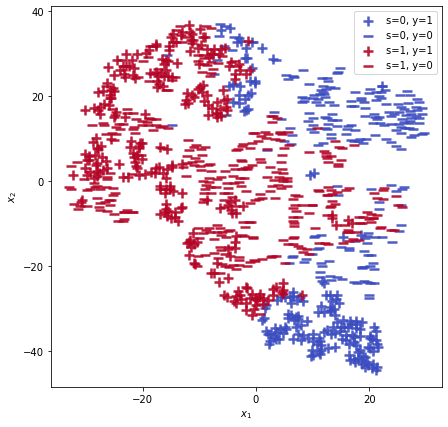

In [18]:
visualize_step_data(gen_train_s, gen_train_x, gen_train_y, step=0)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.005s...
[t-SNE] Computed neighbors for 1000 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.088239
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.218666
[t-SNE] KL divergence after 1000 iterations: 0.848633


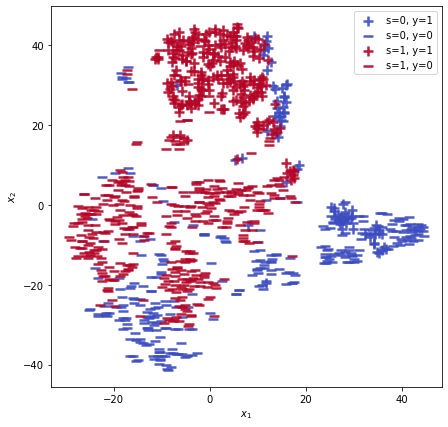

In [19]:
visualize_step_data(gen_train_s, gen_train_x, gen_train_y, step=-1)

Real shape: (250, 10, 6)
Syn shape: (250, 10, 6)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.002s...
[t-SNE] Computed neighbors for 5000 samples in 0.187s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.071678
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.774048
[t-SNE] KL divergence after 1000 iterations: 1.034526


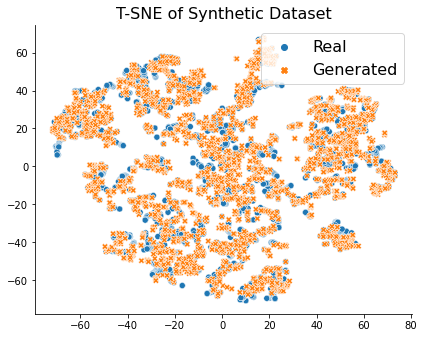

In [20]:
visualization(x_test, gen_test_x[:, 0:10], tsne_path)

# 4. Retrain Classifier

In [21]:
true_model = copy.deepcopy(clf)
re_clf = copy.deepcopy(clf)

In [22]:
risk_minimization(batch_size, seq_len, true_model, re_clf, generator, gen_train_loader, dp_lambda, device, re_clf_path, criterion='eo')
re_clf.load_state_dict(torch.load(re_clf_path, map_location=device))

Save
epochs: 1, loss: 44.95850
Save
epochs: 2, loss: 41.70247
epochs: 3, loss: 42.82250
epochs: 4, loss: 43.80262
epochs: 5, loss: 42.95420
epochs: 6, loss: 42.02901
Save
epochs: 7, loss: 40.54364
Save
epochs: 8, loss: 39.93538
Save
epochs: 9, loss: 39.58344
epochs: 10, loss: 40.13654
epochs: 11, loss: 40.52998
epochs: 12, loss: 39.65931
Save
epochs: 13, loss: 38.88139
epochs: 14, loss: 39.81660
epochs: 15, loss: 39.58323
epochs: 16, loss: 40.43389
epochs: 17, loss: 39.63814
epochs: 18, loss: 39.33990
epochs: 19, loss: 39.30833
epochs: 20, loss: 40.29121
Save
epochs: 21, loss: 38.76231
epochs: 22, loss: 39.13289
epochs: 23, loss: 39.74094
epochs: 24, loss: 39.66288
epochs: 25, loss: 38.99932
Save
epochs: 26, loss: 38.63839
epochs: 27, loss: 38.81778
epochs: 28, loss: 38.87934
epochs: 29, loss: 39.11194
Save
epochs: 30, loss: 38.50055
epochs: 31, loss: 38.92945
epochs: 32, loss: 38.55093
epochs: 33, loss: 39.11999
epochs: 34, loss: 38.58268
epochs: 35, loss: 39.05984
epochs: 36, loss: 3

epochs: 294, loss: 38.26212
epochs: 295, loss: 38.31561
epochs: 296, loss: 38.45331
epochs: 297, loss: 38.74514
epochs: 298, loss: 38.12443
Save
epochs: 299, loss: 37.49239
epochs: 300, loss: 38.00383
epochs: 301, loss: 38.21180
epochs: 302, loss: 37.71794
epochs: 303, loss: 38.72153
epochs: 304, loss: 38.05611
epochs: 305, loss: 38.58128
epochs: 306, loss: 38.19270
epochs: 307, loss: 38.48118
epochs: 308, loss: 38.86377
epochs: 309, loss: 38.29041
epochs: 310, loss: 37.74792
epochs: 311, loss: 38.41564
epochs: 312, loss: 38.34230
epochs: 313, loss: 38.26994
epochs: 314, loss: 38.27063
epochs: 315, loss: 38.54348
epochs: 316, loss: 38.71803
epochs: 317, loss: 38.57327
epochs: 318, loss: 38.77054
epochs: 319, loss: 38.12763
epochs: 320, loss: 37.88559
epochs: 321, loss: 38.16201
epochs: 322, loss: 38.09819
epochs: 323, loss: 38.22769
epochs: 324, loss: 38.02702
epochs: 325, loss: 38.12414
epochs: 326, loss: 38.06904
epochs: 327, loss: 38.15699
epochs: 328, loss: 38.25389
epochs: 329, lo

<All keys matched successfully>

In [23]:
valid_classifier(seq_len, true_model, re_clf, generator, gen_valid_loader, device, criterion='eo')

Step:     0, ACC:83.800%, DP/EO-Fair: -0.131, Short-Fair:-0.041, Long-Fair:-0.202, W-dist:0.3284
Step:     1, ACC:88.300%, DP/EO-Fair: -0.050, Short-Fair:-0.111, Long-Fair:-0.107, W-dist:0.3065
Step:     2, ACC:89.400%, DP/EO-Fair:  0.006, Short-Fair:-0.165, Long-Fair:-0.050, W-dist:0.3214
Step:     3, ACC:91.000%, DP/EO-Fair:  0.013, Short-Fair:-0.073, Long-Fair: 0.063, W-dist:0.3093
Step:     4, ACC:89.700%, DP/EO-Fair: -0.028, Short-Fair:-0.132, Long-Fair: 0.079, W-dist:0.3132
Step:     5, ACC:90.800%, DP/EO-Fair:  0.003, Short-Fair:-0.101, Long-Fair: 0.089, W-dist:0.3190
Step:     6, ACC:91.300%, DP/EO-Fair:  0.039, Short-Fair:-0.091, Long-Fair: 0.110, W-dist:0.3249
Step:     7, ACC:93.900%, DP/EO-Fair:  0.003, Short-Fair:-0.084, Long-Fair: 0.127, W-dist:0.3263
Step:     8, ACC:92.800%, DP/EO-Fair:  0.004, Short-Fair:-0.116, Long-Fair: 0.128, W-dist:0.3177
Step:     9, ACC:90.300%, DP/EO-Fair:  0.014, Short-Fair:-0.119, Long-Fair: 0.121, W-dist:0.3184
Step:    10, ACC:91.600%, DP/E

(-0.10379746556282043, 0.12070300240610943)

In [24]:
valid_classifier(seq_len, true_model, re_clf, generator, gen_test_loader, device, criterion='eo')

Step:     0, ACC:86.700%, DP/EO-Fair: -0.092, Short-Fair:-0.042, Long-Fair:-0.167, W-dist:0.3125
Step:     1, ACC:87.700%, DP/EO-Fair:  0.024, Short-Fair:-0.088, Long-Fair:-0.042, W-dist:0.2892
Step:     2, ACC:89.450%, DP/EO-Fair:  0.043, Short-Fair:-0.142, Long-Fair: 0.012, W-dist:0.3052
Step:     3, ACC:90.150%, DP/EO-Fair:  0.078, Short-Fair:-0.076, Long-Fair: 0.123, W-dist:0.2903
Step:     4, ACC:88.650%, DP/EO-Fair:  0.025, Short-Fair:-0.134, Long-Fair: 0.095, W-dist:0.2941
Step:     5, ACC:90.250%, DP/EO-Fair:  0.037, Short-Fair:-0.124, Long-Fair: 0.127, W-dist:0.2986
Step:     6, ACC:90.500%, DP/EO-Fair:  0.025, Short-Fair:-0.115, Long-Fair: 0.156, W-dist:0.3074
Step:     7, ACC:90.150%, DP/EO-Fair:  0.043, Short-Fair:-0.109, Long-Fair: 0.143, W-dist:0.3049
Step:     8, ACC:89.650%, DP/EO-Fair:  0.032, Short-Fair:-0.135, Long-Fair: 0.142, W-dist:0.2972
Step:     9, ACC:91.050%, DP/EO-Fair:  0.025, Short-Fair:-0.131, Long-Fair: 0.159, W-dist:0.3011
Step:    10, ACC:89.600%, DP/E

(-0.12280701845884323, 0.15875226037844659)

### 4.1 Visualization

In [25]:
gen_train_loader, gen_train_s, gen_train_x, gen_train_y = generate_dataset_from_gan(train_loader, re_clf, generator, device)
gen_valid_loader, gen_valid_s, gen_valid_x, gen_valid_y = generate_dataset_from_gan(valid_loader, re_clf, generator, device)
gen_test_loader, gen_test_s, gen_test_x, gen_test_y = generate_dataset_from_gan(test_loader, re_clf, generator, device)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.089818
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.565460
[t-SNE] KL divergence after 1000 iterations: 1.005143


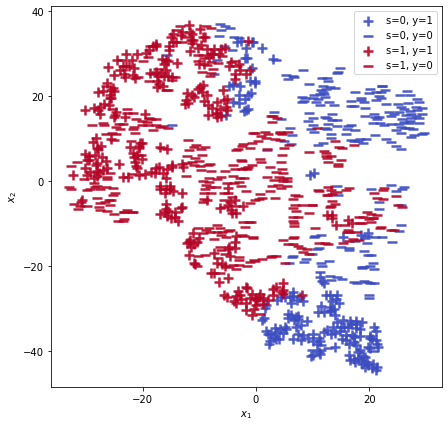

In [26]:
visualize_step_data(gen_train_s, gen_train_x, gen_train_y, step=0)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.026s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.088015
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.185951
[t-SNE] KL divergence after 1000 iterations: 0.842050


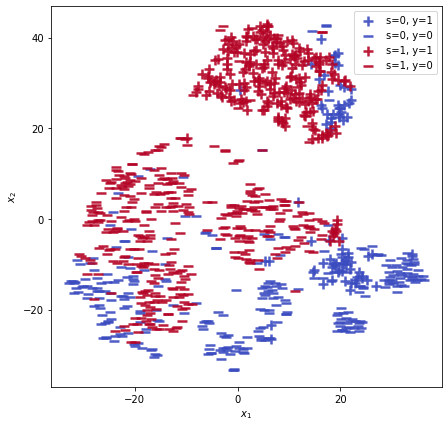

In [27]:
visualize_step_data(gen_train_s, gen_train_x, gen_train_y, step=-1)

In [28]:
data_distance(gen_train_s, gen_train_x[:, 0])
data_distance(gen_valid_s, gen_valid_x[:, 0])
data_distance(gen_test_s, gen_test_x[:, 0])
print("")
data_distance(gen_train_s, gen_train_x[:, -1])
data_distance(gen_valid_s, gen_valid_x[:, -1])
data_distance(gen_test_s, gen_test_x[:, -1])

X0-X1-W-dis: tensor(0.2944)
X0-X1-W-dis: tensor(0.3284)
X0-X1-W-dis: tensor(0.3125)

X0-X1-W-dis: tensor(0.2821)
X0-X1-W-dis: tensor(0.3161)
X0-X1-W-dis: tensor(0.2957)


## Result